In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Set parameters for training
EPOCHS = 5           # Number of epochs
BATCH_SIZE = 64      # Batch size
LEARNING_RATE = 0.001  # Learning rate

In [3]:
# Define transformations for the training and testing datasets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),              # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


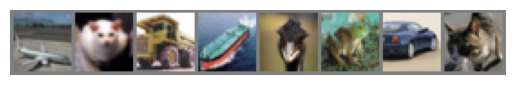

Labels: ['plane', 'cat', 'truck', 'ship', 'bird', 'frog', 'car', 'cat']


In [5]:
# Function to display sample images from the dataset
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))  # Display first 8 images
print("Labels:", [classes[label] for label in labels[:8]])


In [8]:
# Define a function to initialize the model
def initialize_model(model_name, num_classes):
    if model_name == "resnet":
        model = torchvision.models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final layer
    elif model_name == "mobilenet":
        model = torchvision.models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust final layer
    else:
        raise ValueError("Model name not recognized. Use 'resnet' or 'mobilenet'.")
    return model.to(device)

# Initialize both ResNet and MobileNet models
num_classes = 10  # CIFAR-10 has 10 classes
resnet_model = initialize_model("resnet", num_classes)
mobilenet_model = initialize_model("mobilenet", num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=LEARNING_RATE)
optimizer_mobilenet = optim.Adam(mobilenet_model.parameters(), lr=LEARNING_RATE)

# Define a function to train and validate the model
def train_and_evaluate(model, optimizer, model_name):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_losses.append(val_loss / len(testloader))
        val_accuracies.append(100 * correct / total)
        
        print(f"{model_name.upper()} Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    # Plot training and validation loss and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name.capitalize()} Training and Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name.capitalize()} Training and Validation Accuracy")
    plt.legend()

    plt.show()

    return model

C:\Users\Akhila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training ResNet Model
RESNET Epoch [1/5], Train Loss: 1.3924, Train Acc: 50.08%, Val Loss: 1.1086, Val Acc: 60.98%
RESNET Epoch [2/5], Train Loss: 1.0127, Train Acc: 64.36%, Val Loss: 0.9624, Val Acc: 66.60%
RESNET Epoch [3/5], Train Loss: 0.8456, Train Acc: 70.71%, Val Loss: 0.8966, Val Acc: 69.35%
RESNET Epoch [4/5], Train Loss: 0.7406, Train Acc: 74.17%, Val Loss: 0.7662, Val Acc: 73.18%
RESNET Epoch [5/5], Train Loss: 0.6644, Train Acc: 76.84%, Val Loss: 0.7278, Val Acc: 75.37%


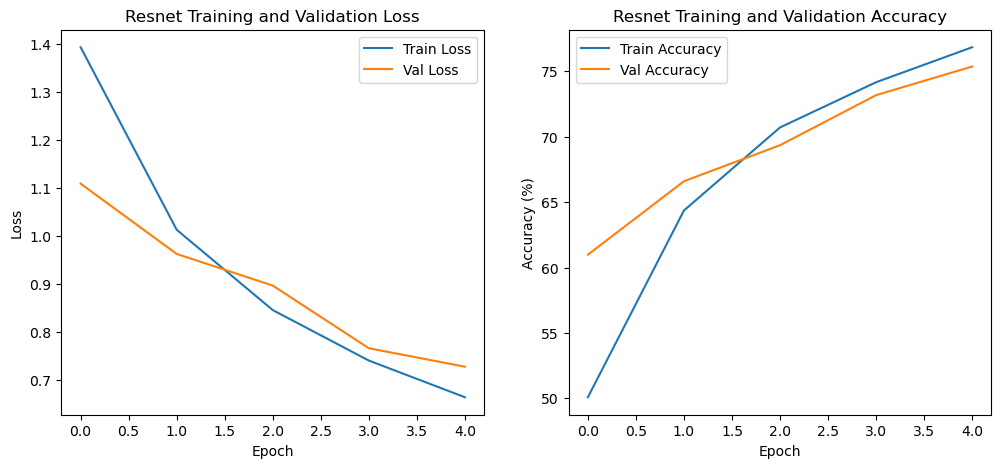

Training MobileNet Model
MOBILENET Epoch [1/5], Train Loss: 0.9737, Train Acc: 67.28%, Val Loss: 0.7767, Val Acc: 74.30%
MOBILENET Epoch [2/5], Train Loss: 0.7674, Train Acc: 74.38%, Val Loss: 0.7683, Val Acc: 72.91%
MOBILENET Epoch [3/5], Train Loss: 0.9415, Train Acc: 68.91%, Val Loss: 1.0477, Val Acc: 65.42%
MOBILENET Epoch [4/5], Train Loss: 0.9868, Train Acc: 67.26%, Val Loss: 0.9331, Val Acc: 68.13%
MOBILENET Epoch [5/5], Train Loss: 0.8966, Train Acc: 69.77%, Val Loss: 0.7663, Val Acc: 74.29%


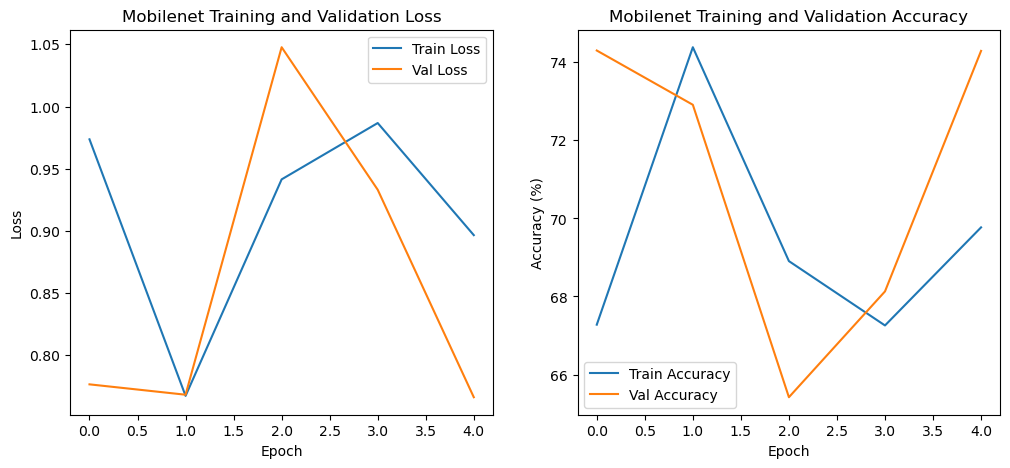

ResNet Test Predictions:


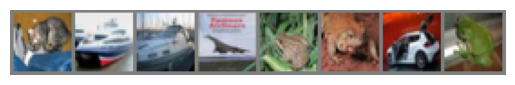

True labels:  cat   ship  ship  plane frog  frog  car   frog 
Resnet Predictions:  cat   ship  ship  plane deer  frog  car   frog 

MobileNet Test Predictions:


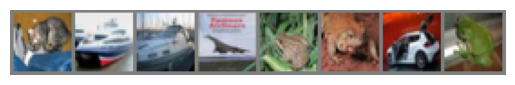

True labels:  cat   ship  ship  plane frog  frog  car   frog 
Mobilenet Predictions:  cat   ship  ship  plane frog  frog  car   frog 


In [9]:
# Train and evaluate ResNet model
print("Training ResNet Model")
resnet_model = train_and_evaluate(resnet_model, optimizer_resnet, "resnet")

# Train and evaluate MobileNet model
print("Training MobileNet Model")
mobilenet_model = train_and_evaluate(mobilenet_model, optimizer_mobilenet, "mobilenet")

# Function to display test predictions
def show_predictions(model, model_name):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    outputs = model(images)
    _, predicted = outputs.max(1)
    
    # Display images with predictions
    imshow(torchvision.utils.make_grid(images[:8].cpu()))
    print("True labels: ", ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
    print(f"{model_name.capitalize()} Predictions: ", ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))

# Show test predictions for both models
print("ResNet Test Predictions:")
show_predictions(resnet_model, "resnet")

print("\nMobileNet Test Predictions:")
show_predictions(mobilenet_model, "mobilenet")
